In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 

In [2]:
import numpy as np
from ripser import ripser
from persim import plot_diagrams

First we test how topological data analysis performs on noisey stationary timeseries (structureless).

<AxesSubplot:xlabel='signal', ylabel='count'>

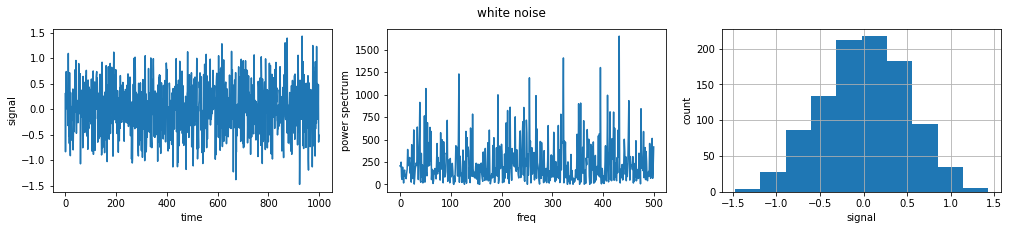

In [3]:
from random import gauss
from random import seed
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.gofplots import qqplot

# seed random number generator
seed(123456)
# create white noise series
white_noise_gen = [gauss(0.0, .50) for i in range(1000)]
white_noise = pd.Series(white_noise_gen)

fig_wn, data = plt.subplots(1, 3, figsize=(17, 3))

fig_wn.suptitle('white noise')
data[0].set_xlabel('time')
data[0].set_ylabel('signal')
data[1].set_xlabel('freq')
data[1].set_ylabel('power spectrum')
data[2].set_xlabel('signal')
data[2].set_ylabel('count')

fft_wn = np.fft.rfft(white_noise)
fft_wn_abs = np.abs(fft_wn)
power_spectrum_wn = np.square(fft_wn_abs)


data[0].plot(white_noise)
data[1].plot(power_spectrum_wn)
white_noise.hist()


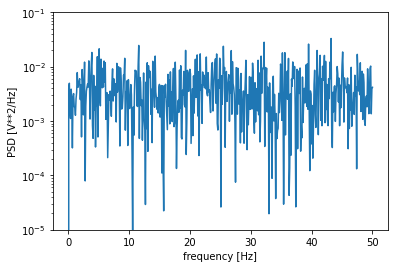

In [5]:
from scipy import signal

f, Pxx_den = signal.periodogram(white_noise, 100)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-5, 1e-1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# the frequency index should be fixed... 

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



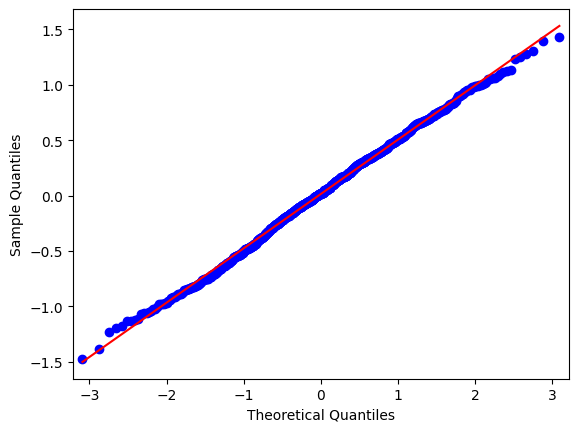

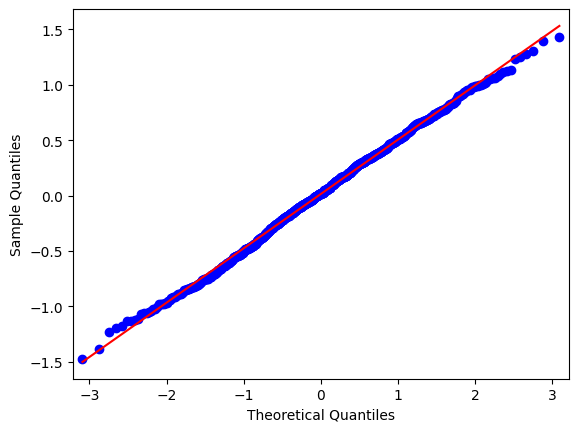

In [86]:
qqplot(white_noise, line='s')

In [87]:
from scipy.stats import anderson

# normality test
result = anderson(white_noise)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.537
15.000: 0.574, data looks normal (fail to reject H0)
10.000: 0.653, data looks normal (fail to reject H0)
5.000: 0.784, data looks normal (fail to reject H0)
2.500: 0.914, data looks normal (fail to reject H0)
1.000: 1.088, data looks normal (fail to reject H0)


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

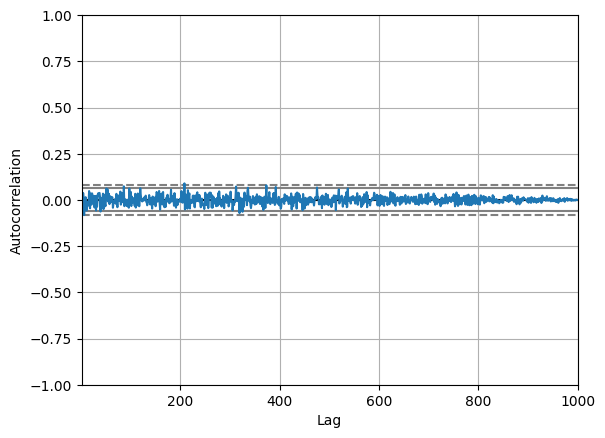

In [88]:
from pandas.plotting import autocorrelation_plot
from scipy import signal

autocorrelation_plot(white_noise)


In [89]:
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud

print('length of signal to analyze', len(white_noise_gen))

max_time_delay = 50 
max_embedding_dimension = 20
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    white_noise_gen, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_wn_embedded = embedder.fit_transform(white_noise_gen)

pca = PCA(n_components=3)
y_wn_embedded_pca = pca.fit_transform(y_wn_embedded)

plot_point_cloud(y_wn_embedded_pca)

length of signal to analyze 1000
Optimal embedding time delay based on mutual information: 2
Optimal embedding dimension based on false nearest neighbors: 6


In [90]:
from gtda.homology import VietorisRipsPersistence
homology_dimensions = (0, 1, 2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)


y_wn_embedded_reshaped = y_wn_embedded.reshape(1, *y_wn_embedded.shape)
print(f"y_wn_embedded_reshaped.shape",y_wn_embedded_reshaped.shape)
print(f"y_wn_embedded.shape", y_wn_embedded.shape)


PerHom_wn = VRP.fit_transform(y_wn_embedded_reshaped)
VRP.plot(PerHom_wn)

y_wn_embedded_reshaped.shape (1, 990, 6)
y_wn_embedded.shape (990, 6)


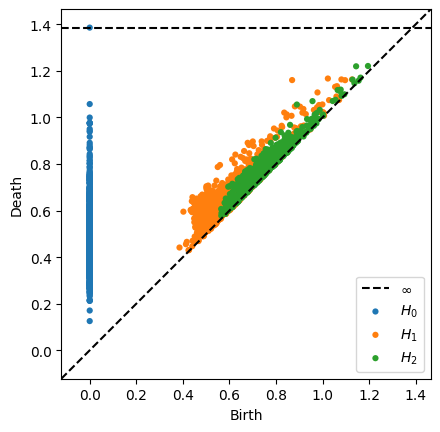

In [91]:
from ripser import ripser
from persim import plot_diagrams

dgms = ripser(y_wn_embedded, maxdim=2)['dgms']
plot_diagrams(dgms, show=True)

In [92]:
from gtda.diagrams import PersistenceEntropy

PE_wn = PersistenceEntropy()
features_wn = PE_wn.fit_transform(PerHom_wn)
features_wn

array([[9.89742503, 9.53417561, 8.96680235]])

In [93]:
from gtda.diagrams import HeatKernel

HK = HeatKernel()
print(PerHom_wn.shape)
for i in [0,1,2]:
    HK_wn = HK.fit_transform_plot(PerHom_wn, homology_dimension_idx = i)


(1, 2703, 3)


In [94]:
from gtda.diagrams import PersistenceImage

PI = PersistenceImage()
for i in [0,1,2]:
    PI_wn = PI.fit_transform_plot(PerHom_wn, homology_dimension_idx = i)


Let's analyse now a slugging event.

In [95]:
slug_1_df = pd.read_csv('slug_1_A-08.csv')

Let's import well data from WDEA data dump. Respectively: Flowline pressure, Flowline temperature and Bottom hole pressure (BHP).

In [96]:
slug_1_df

Unnamed: 0  Flowline Pressure  Flowline Temperature      BHP
0      2020-04-12 00:00:00            9.27104               92.3331  164.069
1      2020-04-12 00:00:10            9.26024               92.3332  164.064
2      2020-04-12 00:00:20            9.26320               92.3104  164.059
3      2020-04-12 00:00:30            9.29199               92.3469  164.052
4      2020-04-12 00:00:40            9.28370               92.3469  164.044
...                    ...                ...                   ...      ...
34555  2020-04-15 23:59:10            9.07936               91.4536  164.240
34556  2020-04-15 23:59:20            9.07979               91.4640  164.198
34557  2020-04-15 23:59:30            9.05922               91.4745  164.155
34558  2020-04-15 23:59:40            9.05307               91.4020  164.112
34559  2020-04-15 23:59:50            9.08433               91.3887  164.071

[34560 rows x 4 columns]

In [97]:
# plotting only 1 point per minutes to shorten process time
reduced_df1 = slug_1_df[::60]
reduced_df1

Unnamed: 0  Flowline Pressure  Flowline Temperature      BHP
0      2020-04-12 00:00:00            9.27104               92.3331  164.069
60     2020-04-12 00:10:00            9.45319               92.3066  164.152
120    2020-04-12 00:20:00            9.12776               92.3426  163.965
180    2020-04-12 00:30:00            9.33394               92.4163  164.219
240    2020-04-12 00:40:00            9.33298               92.3861  164.011
...                    ...                ...                   ...      ...
34260  2020-04-15 23:10:00            9.30618               91.3470  164.323
34320  2020-04-15 23:20:00            9.14418               91.5483  164.304
34380  2020-04-15 23:30:00            9.08884               91.5550  164.366
34440  2020-04-15 23:40:00            9.34818               91.6642  164.096
34500  2020-04-15 23:50:00            9.14668               91.4201  164.432

[576 rows x 4 columns]

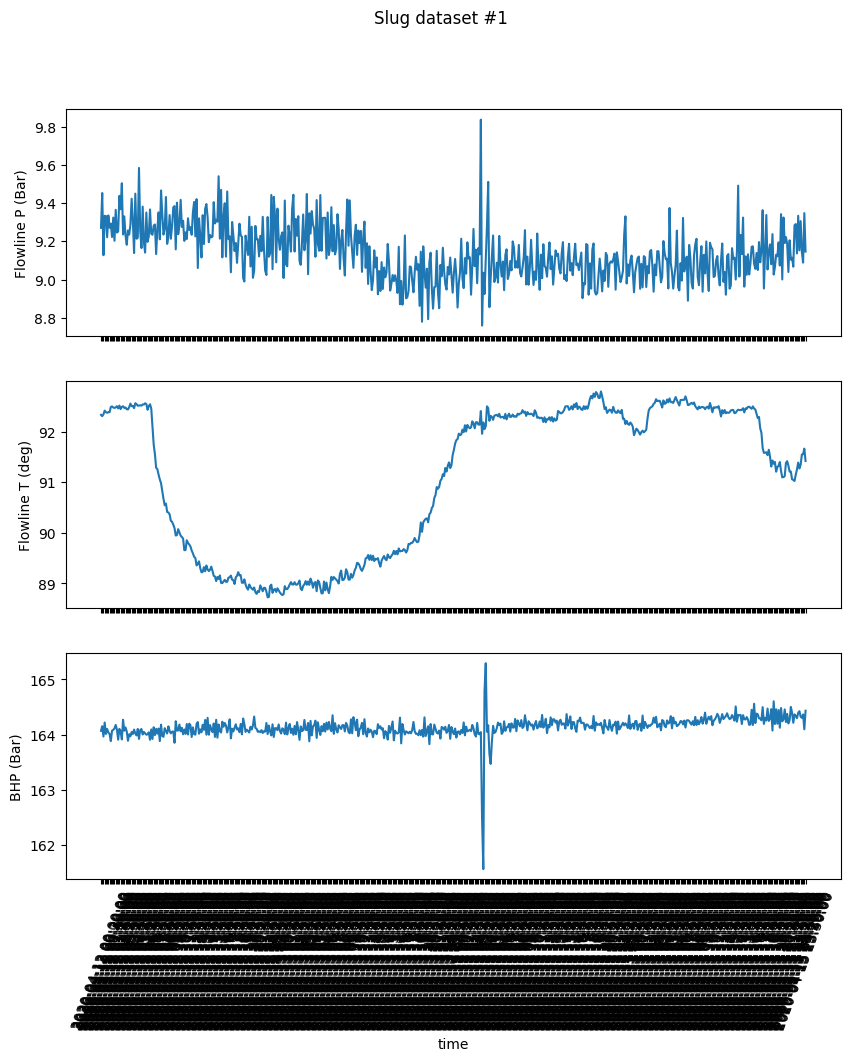

In [98]:
fig, ts = plt.subplots(3,figsize=(10,10),sharex = True)

fig.suptitle('Slug dataset #1')
ts[2].set_xlabel('time')
ts[0].set_ylabel('Flowline P (Bar)')
ts[1].set_ylabel('Flowline T (deg)')
ts[2].set_ylabel('BHP (Bar)')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(reduced_df1[reduced_df1.columns[0]], reduced_df1["Flowline Pressure"])
ts[1].plot(reduced_df1[reduced_df1.columns[0]], reduced_df1["Flowline Temperature"])
ts[2].plot(reduced_df1[reduced_df1.columns[0]], reduced_df1["BHP"])


Is the steady state production in the timeseries a true white noise?

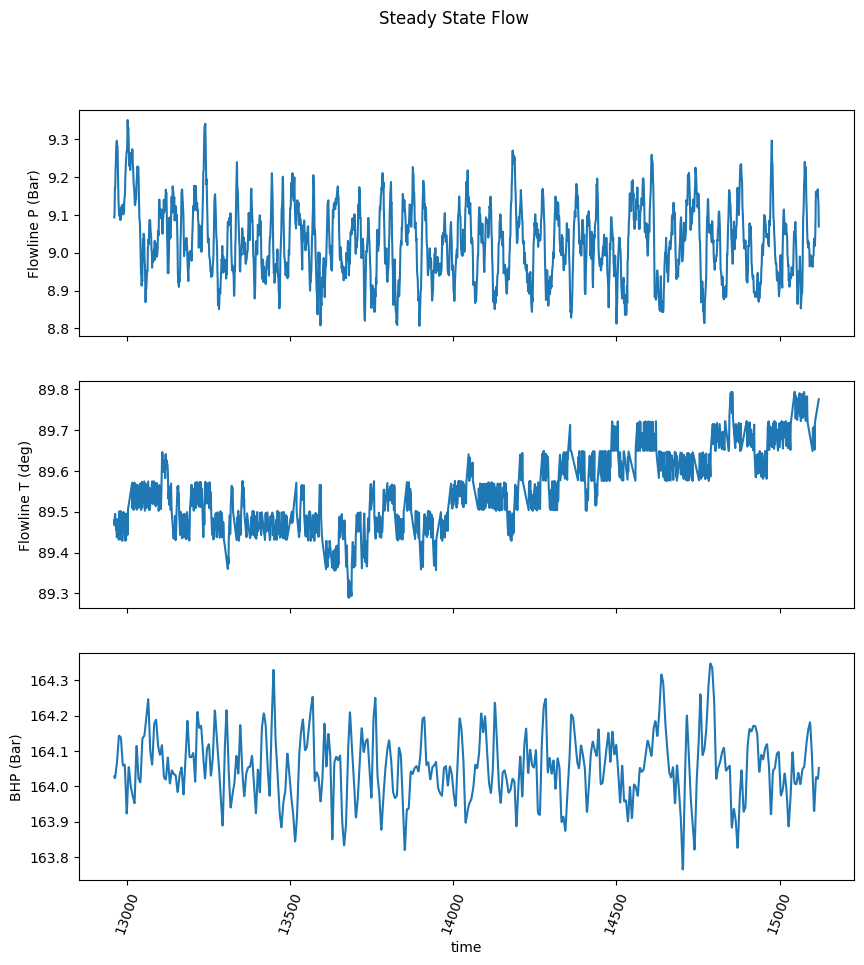

In [99]:
start_date = '2020-04-13 12:00:00'
end_date = '2020-04-13 18:00:00'
mask_ss = (slug_1_df[slug_1_df.columns[0]] > start_date) & (slug_1_df[slug_1_df.columns[0]] <= end_date)

steady_state = slug_1_df.loc[mask_ss]

fig_ss, ts_ss = plt.subplots(3,figsize=(10,10),sharex = True)

fig_ss.suptitle('Steady State Flow')
ts_ss[2].set_xlabel('time')
ts_ss[0].set_ylabel('Flowline P (Bar)')
ts_ss[1].set_ylabel('Flowline T (deg)')
ts_ss[2].set_ylabel('BHP (Bar)')

degrees = 70
plt.xticks(rotation=degrees)

ts_ss[0].plot(steady_state.index, steady_state["Flowline Pressure"])
ts_ss[1].plot(steady_state.index, steady_state["Flowline Temperature"])
ts_ss[2].plot(steady_state.index, steady_state["BHP"])

<AxesSubplot:xlabel='signal', ylabel='count'>

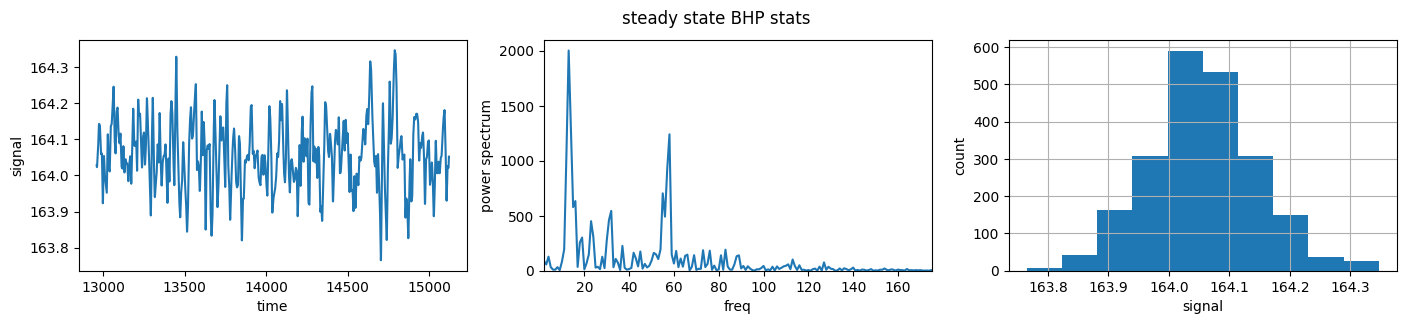

In [100]:
fig_ss_analysis, data = plt.subplots(1, 3, figsize=(17, 3))

fig_ss_analysis.suptitle('steady state BHP stats')
data[0].set_xlabel('time')
data[0].set_ylabel('signal')
data[1].set_xlabel('freq')
data[1].set_ylabel('power spectrum')
data[2].set_xlabel('signal')
data[2].set_ylabel('count')

data[1].set_xlim(2,175)
data[1].set_ylim(0,2100)

#ss_BHP = slug_1_df['BHP'].to_numpy()
ss_BHP = steady_state['BHP']

fft_ss = np.fft.rfft(ss_BHP)
fft_ss_abs = np.abs(fft_ss)
power_spectrum_ss = np.square(fft_ss_abs)


data[0].plot(ss_BHP)
data[1].plot(power_spectrum_ss)
ss_BHP.hist()


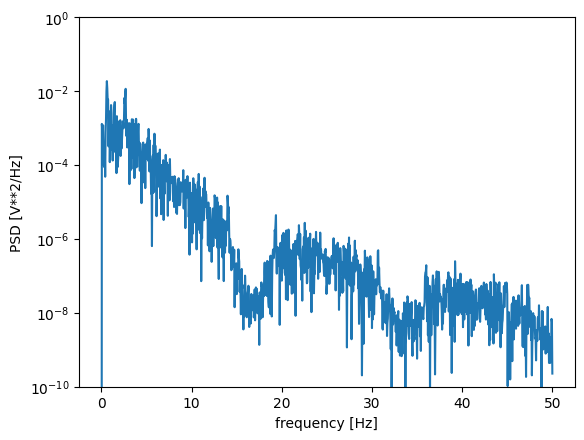

In [101]:
f, Pxx_den = signal.periodogram(ss_BHP, 100)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-10, 1e0])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

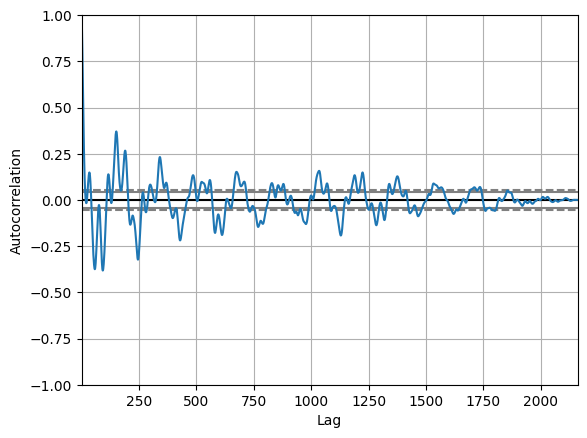

In [102]:
autocorrelation_plot(ss_BHP)

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



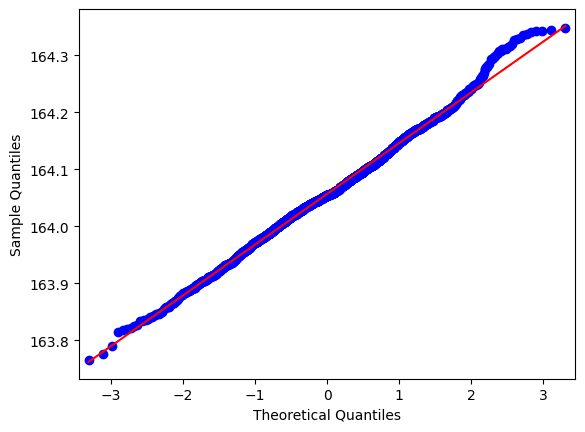

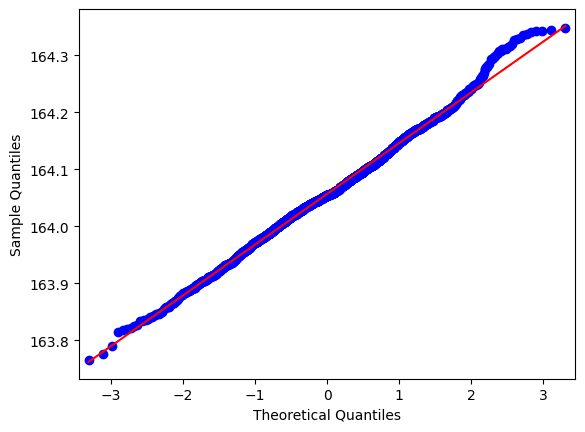

In [103]:
qqplot(ss_BHP, line='s')

In [104]:
# normality test
result = anderson(ss_BHP)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 2.033
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.916, data does not look normal (reject H0)
1.000: 1.090, data does not look normal (reject H0)


/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



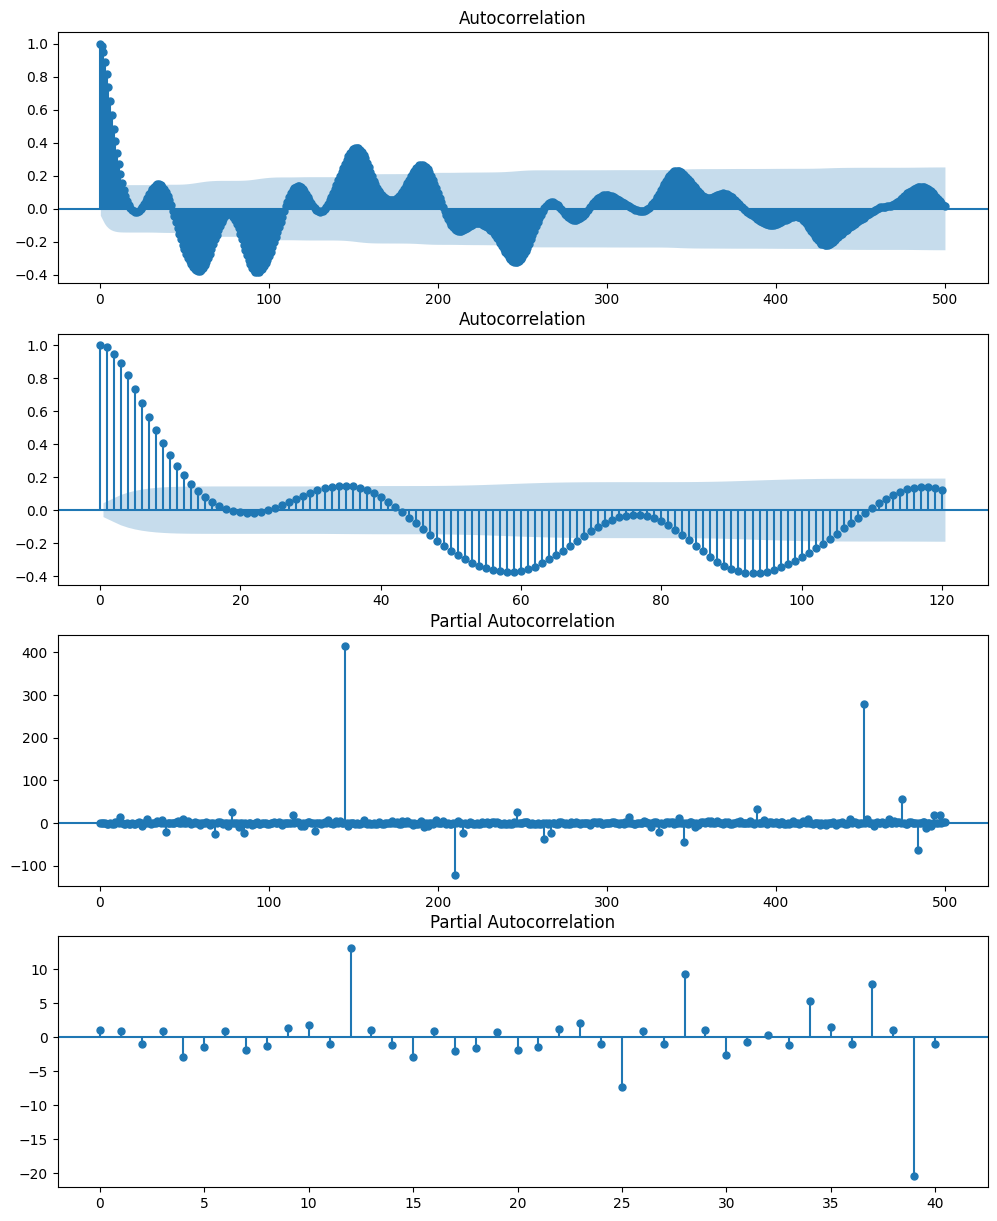

In [105]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,15))
ax1 = fig.add_subplot(411)
fig = sm.graphics.tsa.plot_acf(ss_BHP.values.squeeze(), lags=500, ax=ax1)
ax2 = fig.add_subplot(412)
fig = sm.graphics.tsa.plot_acf(ss_BHP.values.squeeze(), lags=120, ax=ax2)
ax3 = fig.add_subplot(413)
fig = sm.graphics.tsa.plot_pacf(ss_BHP, lags=500, ax=ax3)
ax4 = fig.add_subplot(414)
fig = sm.graphics.tsa.plot_pacf(ss_BHP, lags=40, ax=ax4)

Well, the BHP data at steady state are not really normally distributed... How does the persisitent homology looks like?

We know when a slugging / irregulaf flow event occurred, so the dataframe is trimmed to a window of a manageable size centered around the event.

In [106]:
#slug_signal = slug_event_1["BHP"]
print('length of signal to analyze', len(ss_BHP))

max_time_delay = 200 
max_embedding_dimension = 10
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    ss_BHP, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_ss_BHP = embedder.fit_transform(ss_BHP)

pca = PCA(n_components=3)
y_ss_BHP_pca = pca.fit_transform(y_ss_BHP)

plot_point_cloud(y_ss_BHP_pca)



length of signal to analyze 2160
Optimal embedding time delay based on mutual information: 20
Optimal embedding dimension based on false nearest neighbors: 6


In [107]:
print('ss_BHP', ss_BHP.size)
ss_BHP_small = ss_BHP.head(1000)
print('ss_BHP_small', ss_BHP_small.size)
print('white_noise_gen', len(white_noise_gen))

# going down to a smaller array to reduce computational cost

ss_BHP 2160
ss_BHP_small 1000
white_noise_gen 1000


In [108]:
#homology_dimensions = (0, 1, 2)
#VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

y_ss_BHP = embedder.fit_transform(ss_BHP_small)

y_ss_BHP_pca = pca.fit_transform(y_ss_BHP)
plot_point_cloud(y_ss_BHP_pca)

In [109]:
y_ss_BHP_reshaped = y_ss_BHP.reshape(1, *y_ss_BHP.shape)
PH_BHP =  VRP.fit_transform(y_ss_BHP_reshaped)
VRP.plot(PH_BHP)

In [157]:
PH_BHP

array([[[0.        , 0.00866025, 0.        ],
        [0.        , 0.00932738, 0.        ],
        [0.        , 0.00979796, 0.        ],
        ...,
        [0.09185859, 0.09281702, 2.        ],
        [0.07513987, 0.0754122 , 2.        ],
        [0.07402702, 0.07441102, 2.        ]]])

In [132]:
PE_BHP = PersistenceEntropy()
features = PE_BHP.fit_transform(PH_BHP)
features 

array([[9.83126389, 7.28953021, 6.52064971]])

In [193]:
HK_BHP = HK.fit_transform(PH_BHP)
HK.plot(HK_BHP)

In [111]:
start_date = '2020-04-14 02:40:00'
end_date = '2020-04-14 06:00:00'
mask = (slug_1_df[slug_1_df.columns[0]] > start_date) & (slug_1_df[slug_1_df.columns[0]] <= end_date)

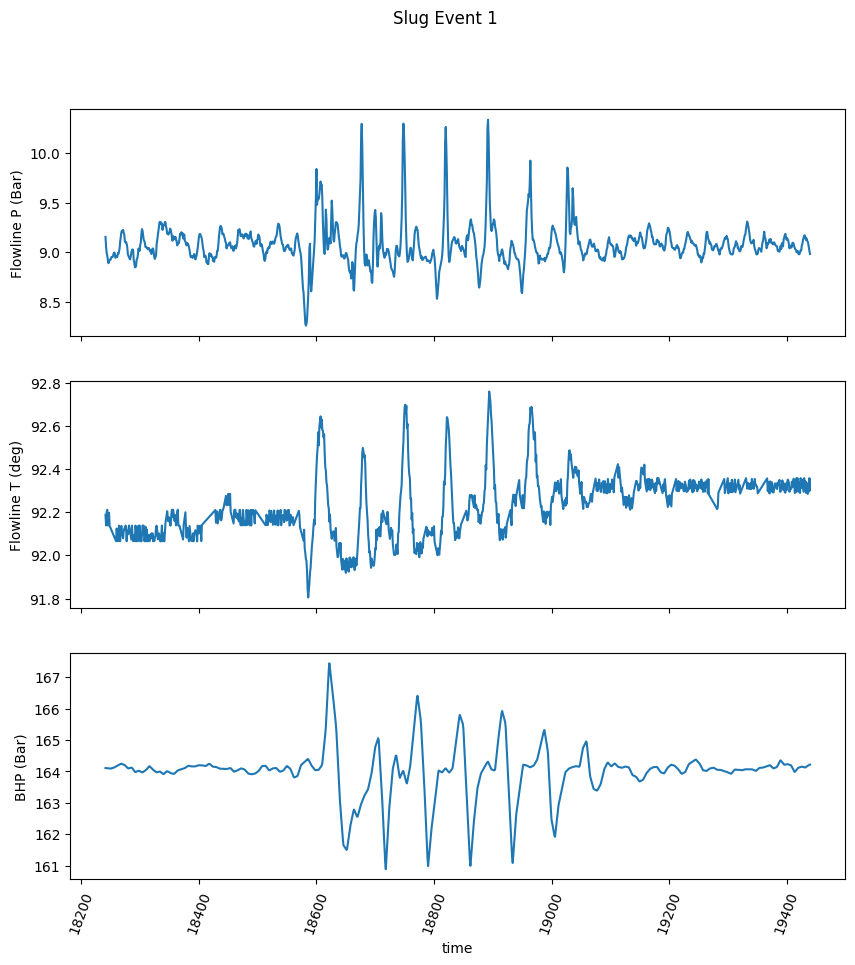

In [112]:
slug_event_1 = slug_1_df.loc[mask]

fig, ts = plt.subplots(3,figsize=(10,10),sharex = True)

fig.suptitle('Slug Event 1')
ts[2].set_xlabel('time')
ts[0].set_ylabel('Flowline P (Bar)')
ts[1].set_ylabel('Flowline T (deg)')
ts[2].set_ylabel('BHP (Bar)')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(slug_event_1.index, slug_event_1["Flowline Pressure"])
ts[1].plot(slug_event_1.index, slug_event_1["Flowline Temperature"])
ts[2].plot(slug_event_1.index, slug_event_1["BHP"])

The three timeseries show similar features: a series of seven peaks with an apparent period of 70 time intervals.
For sake of testing we focus here on BHP and apply a Taken embedding. 

There has been extensive work on understanding the behavior of the underlying dynamical system given only a 
time series [1, 2]. The revolutionary work of Takens [3] extended by Sauer et al. [4] showed that, 
given most choices of parameters, the state-space of the dynamical system can be reconstructed through the 
Takens’embedding. Computationally, this arises
as the following procedure. Given a time series [x1,··· , xn], a
choice of dimension d and time lag τ give rise to a point cloud
χ = {xi:= (xi, xi+τ ,··· ,(xi+(d−1)τ)} ⊂ R_d. 

Then the goal is
to analyze this point cloud, which really is a sampling of the
full state space, in a way that the dynamics can be understood.

In [113]:
slug_signal = slug_event_1["BHP"]
print('length of signal to analyze', len(slug_signal))

max_time_delay = 200 
max_embedding_dimension = 9
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    slug_signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

length of signal to analyze 1200
Optimal embedding time delay based on mutual information: 115
Optimal embedding dimension based on false nearest neighbors: 6


In [114]:
embedding_dimension = 6
embedding_time_delay = 115
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_slug_embedded = embedder.fit_transform(slug_signal)

pca = PCA(n_components=3)
y_slug_embedded_pca = pca.fit_transform(y_slug_embedded)

plot_point_cloud(y_slug_embedded_pca)

In [115]:
homology_dimensions = (0, 1, 2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

#y_slug_embedded.reshape(1, *y_slug_embedded.shape)
# the array need to be reshaped as the library expects many 2D arrays of dimensions n_windows x window_size

y_slug_embedded_reshaped = y_slug_embedded.reshape(1, *y_slug_embedded.shape)
print(f"y_slug_embedded_reshaped.shape",y_slug_embedded_reshaped.shape)
print(f"y_slug_embedded.shape", y_slug_embedded.shape)


X_diagrams = VRP.fit_transform(y_slug_embedded_reshaped)
VRP.plot(X_diagrams)

y_slug_embedded_reshaped.shape (1, 625, 6)
y_slug_embedded.shape (625, 6)


In [116]:
PE_slug = PersistenceEntropy()
features = PE_slug.fit_transform(X_diagrams)

In [117]:
features

array([[9.21605907, 5.91764823, 2.99703489]])

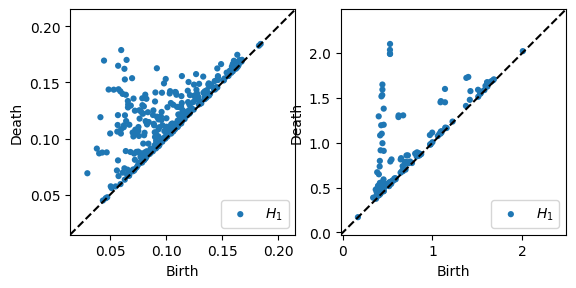

In [152]:
dgms_steady = ripser(y_ss_BHP, maxdim=2)['dgms']
dgms_slug = ripser(y_slug_embedded, maxdim=2)['dgms']

plot_diagrams(dgms_steady, plot_only=[1], ax=plt.subplot(121))
plot_diagrams(dgms_slug, plot_only=[1], ax=plt.subplot(122))

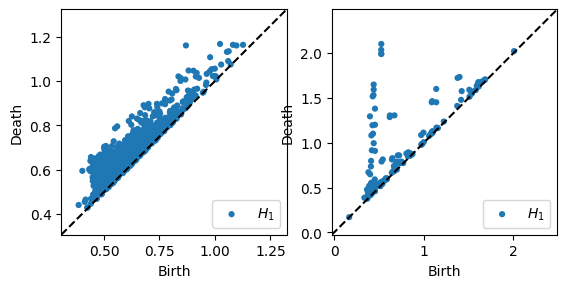

In [180]:
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(121))
plot_diagrams(dgms_slug, plot_only=[1], ax=plt.subplot(122))

In [185]:
from persim import bottleneck, wasserstein

#Bottleneck distance for H1 of steady state vs slugging 
d_bottle = bottleneck(dgms_steady[1], dgms_slug[1], matching=False)
d_wasserstein = wasserstein(dgms_steady[1], dgms_slug[1], matching=False)

print('bottleneck distance steady state vs slugging', d_bottle)
print('wasserstein distance steady state vs slugging', d_wasserstein)

bottleneck distance steady state vs slugging 0.7884823083877563
wasserstein distance steady state vs slugging 24.429991811989606


In [189]:
#Bottleneck distance for H1 of white noise vs slugging
d_bottle = bottleneck(dgms[1], dgms_slug[1], matching=False)
d_wasserstein = wasserstein(dgms[1], dgms_slug[1], matching=False)

print('bottleneck distance white noise vs slugging', d_bottle)
print('wasserstein distance white noise state vs slugging', d_wasserstein)

bottleneck distance white noise vs slugging 0.7884823083877563
wasserstein distance white noise state vs slugging 52.860367507225476


In [187]:
#test 'self' distance (zero by definition)
d_bottle = bottleneck(dgms_slug[1], dgms_slug[1], matching=False)
d_wasserstein = wasserstein(dgms_slug[1], dgms_slug[1], matching=False)
print('bottleneck distance white noise vs slugging', d_bottle)
print('wasserstein distance white noise state vs slugging', d_wasserstein)

bottleneck distance white noise vs slugging 0.0
wasserstein distance white noise state vs slugging 0.0


In [118]:
X_diagrams 

array([[[0.        , 0.05736724, 0.        ],
        [0.        , 0.05871967, 0.        ],
        [0.        , 0.06055576, 0.        ],
        ...,
        [1.32914555, 1.33369863, 2.        ],
        [1.30462682, 1.30591881, 2.        ],
        [0.83077973, 0.8368417 , 2.        ]]])

In [120]:
dgms[1]

array([[1.12655997, 1.16331208],
       [1.09701037, 1.16024971],
       [1.08113158, 1.16334486],
       ...,
       [0.41332838, 0.4556511 ],
       [0.40236029, 0.59540516],
       [0.38564891, 0.4414092 ]])

In [190]:
HK_slug = HK.fit_transform_plot(X_diagrams, homology_dimension_idx=1)
HK_steady = HK.fit_transform_plot(PH_BHP, homology_dimension_idx=1)
HK_wn = HK.fit_transform_plot(PerHom_wn, homology_dimension_idx = 1)

PI_wn = PI.fit_transform_plot(PerHom_wn, homology_dimension_idx=1)
PI_steady = PI.fit_transform_plot(PH_BHP, homology_dimension_idx=1)
PI_slug = PI.fit_transform_plot(X_diagrams, homology_dimension_idx=1)

In [191]:
from gtda.diagrams import BettiCurve 

Betti = BettiCurve()
Betti_wn = Betti.fit_transform_plot(PerHom_wn)
Betti_slug = Betti.fit_transform_plot(X_diagrams)

In [192]:
print('slug PH shape',X_diagrams.shape, 'white noise PH shape', PerHom_wn.shape) 
PerHom_wn_shrink = np.reshape(PerHom_wn, (1,807,3))
Diagrams = np.append(X_diagrams,PerHom_wn_shrink,axis=0)
Diagrams.shape

slug PH shape (1, 807, 3) white noise PH shape (1, 2703, 3)


ValueError: cannot reshape array of size 8109 into shape (1,807,3)

In [ ]:
from gtda.diagrams import PairwiseDistance
metrics = ['bottleneck', 'wasserstein', 'betti', 'landscape', 'silhouette', 'heat', 'image']

for metric in metrics:
    tmp = PairwiseDistance(metric=metric)
    print(metric, tmp)

In [ ]:
print(type(X_diagrams), X_diagrams.shape)
X_diagrams

In [ ]:
print(type(dgms[1]), dgms[1].shape)
dgms[1]

In [ ]:
X_diagrams_H1 = X_diagrams[:,:,1]
X_diagrams.shape
#X_diagrams


In [ ]:
X_diagrams[0,700:807,:]

In [ ]:
#X_diagrams_H1 = np.zeros(shape=(1,3))
X_diagrams_H1 = []

for i in X_diagrams:
    for y in i:
        if y[2] == 1:
            tmpy = [y[0],y[1]]
            #print(tmpy)
            #np.append(X_diagrams_H1, tmpy) 
            X_diagrams_H1.append(tmpy)

X_diagrams_H1 = np.asarray(X_diagrams_H1) 
X_diagrams_H1

In [ ]:
pimgr = PersistenceImager(pixel_size=1)
pimgr.fit(X_diagrams_H1)
#imgs = pimgr.transform(dgms[1])

fig_img, axs = plt.subplots(1, 3, figsize=(20,5))
pimgr.plot_diagram(X_diagrams_H1, skew=True, ax=axs[0])
axs[0].set_title('Diagram', fontsize=16)

pimgr.plot_image(pimgr.transform(X_diagrams_H1), ax=axs[1])
axs[1].set_title('Pixel Size: 1', fontsize=16)

pimgr.pixel_size = 0.01
pimgr.plot_image(pimgr.transform(X_diagrams_H1), ax=axs[2])
axs[2].set_title('Pixel Size: 0.01', fontsize=16)

plt.tight_layout()